# Imports

In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

import time

import torch
import torch.nn as nn
from torchsummary import summary

# Testset Modification (Addition of anomalies)

In [2]:
df = pd.read_csv("data/mnist_test.csv")
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Arbitrarily choose first 1000 for corruption

anom = df[:1000]
clean = df[1000:]

In [4]:
# Function for displaying the MNIST image

def show_mnist_image(data):
    # The first column is the label
    label = data[0]
    
    # The rest of columns are pixels
    pixels = data[1:]
    
    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(pixels, dtype='int64')
    #print(pixels.shape)
    
    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((28, 28))
    #print(pixels.shape)
    
    # Plot
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap='gray')
    plt.show();

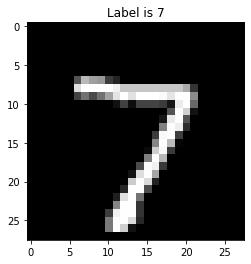

In [5]:
show_mnist_image(df.iloc[0])

In [6]:
# Apply corruption

for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [7]:
# Change the label (1 for anomaly, 0 for clean)

anom.loc[:, 'label'] = 1
clean.loc[:, 'label'] = 0

C:\Users\johnw\AppData\Local\Temp\ipykernel_15656\1565456563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom.loc[:, 'label'] = 1
C:\Users\johnw\AppData\Local\Temp\ipykernel_15656\1565456563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:, 'label'] = 0


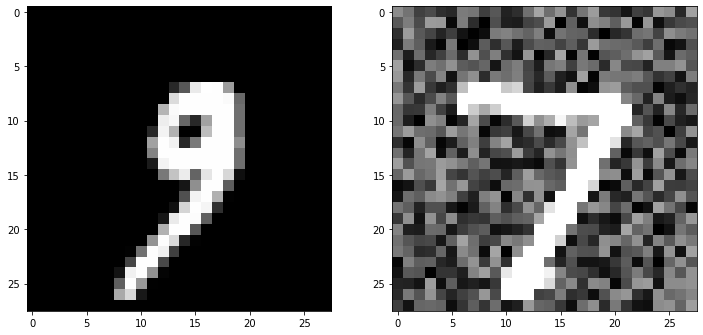

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.array(clean.iloc[0, 1:]).reshape(28, 28), cmap='gray')
axs[1].imshow(np.array(anom.iloc[0, 1:]).reshape(28, 28), cmap='gray')

plt.show();

In [9]:
# Recombine the test sets

an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('data/mnist_test_anom.csv')          # save

# Autoencoder

In [10]:
# Autoencoder Class

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
        
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [11]:
# Training Parameters

batch_size = 32
lr = 1e-2   # learning rate
w_d = 1e-5  # weight decay
momentum = 0.9
epochs = 15

In [12]:
# Loader Preparation

class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()  # Normalize
        return data
    
class TrainLoader(Loader):
    def __init__(self):
        super(TrainLoader, self).__init__()
        self.dataset = pd.read_csv(
            'data/mnist_train.csv', index_col=False
        )

In [13]:
train_set = TrainLoader()

train_ = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=20,
    pin_memory=True,
    drop_last=True
)

In [14]:
metrics = defaultdict(list)
device = 'cpu'       #'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [15]:
summary(model, (1, 784), device='cpu');  # Must use device='cpu'

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 16]               --
|    └─Linear: 2-1                       [-1, 1, 512]              401,920
|    └─ReLU: 2-2                         [-1, 1, 512]              --
|    └─Linear: 2-3                       [-1, 1, 256]              131,328
|    └─ReLU: 2-4                         [-1, 1, 256]              --
|    └─Linear: 2-5                       [-1, 1, 128]              32,896
|    └─ReLU: 2-6                         [-1, 1, 128]              --
|    └─Linear: 2-7                       [-1, 1, 64]               8,256
|    └─ReLU: 2-8                         [-1, 1, 64]               --
|    └─Linear: 2-9                       [-1, 1, 32]               2,080
|    └─ReLU: 2-10                        [-1, 1, 32]               --
|    └─Linear: 2-11                      [-1, 1, 16]               528
|    └─ReLU: 2-12                        [-1, 1, 16]            

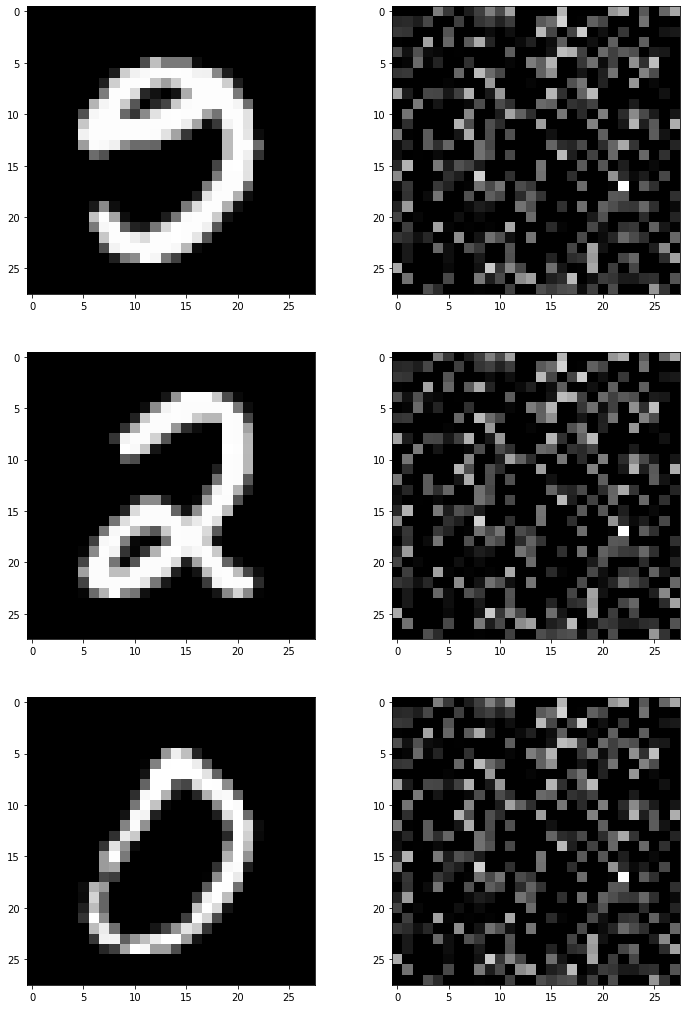

In [16]:
# Autoencoder outputs (Train Set) - Before Training

with torch.no_grad():

    data = next(iter(train_))
    sample = model(data.to(device))
    _, axs = plt.subplots(3, 2, figsize=(12, 18))
    axs[0, 0].imshow(np.array(data[0]).reshape(28, 28), cmap='gray')
    axs[0, 1].imshow(np.array(sample[0]).reshape(28, 28), cmap='gray')
    axs[1, 0].imshow(np.array(data[1]).reshape(28, 28), cmap='gray')
    axs[1, 1].imshow(np.array(sample[1]).reshape(28, 28), cmap='gray')
    axs[2, 0].imshow(np.array(data[2]).reshape(28, 28), cmap='gray')
    axs[2, 1].imshow(np.array(sample[2]).reshape(28, 28), cmap='gray')

In [17]:
# Training

model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.00338119728192687
Epoch Complete in 0:01:20.230996
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003302929202343027
Epoch Complete in 0:01:20.574998
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.003223242925480008
Epoch Complete in 0:01:10.316000
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0031381741100301344
Epoch Complete in 0:01:01.430999
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.003049684783692161
Epoch Complete in 0:00:56.375000
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0029551639585445326
Epoch Complete in 0:00:55.950002
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0028674445868780217
Epoch Complete in 0:00:54.635000
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002799528557062149
Epoch Complete in 0:00:56.902037
----------------------

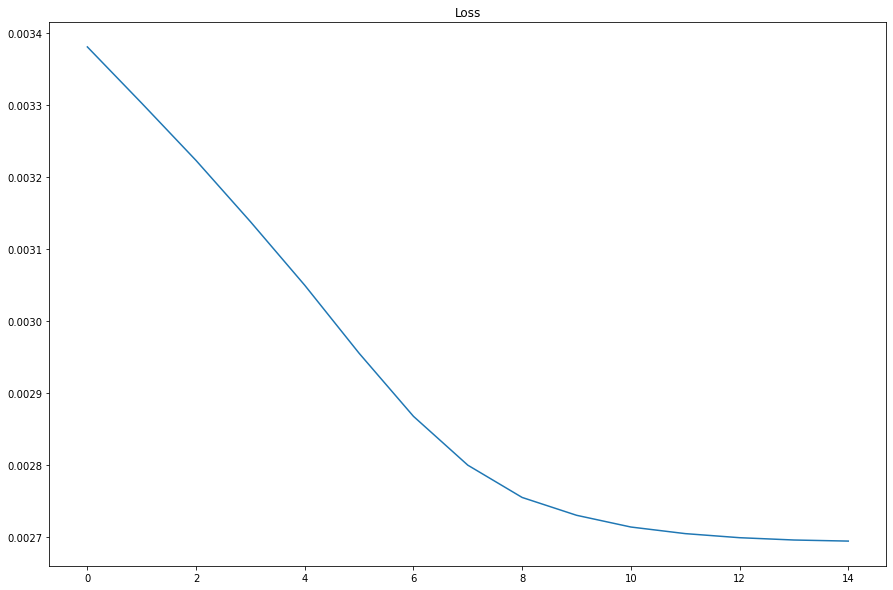

In [18]:
# Training Loss

_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

# Prediction

In [19]:
model.eval()
loss_dist = []
anom = pd.read_csv('data/mnist_test_anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

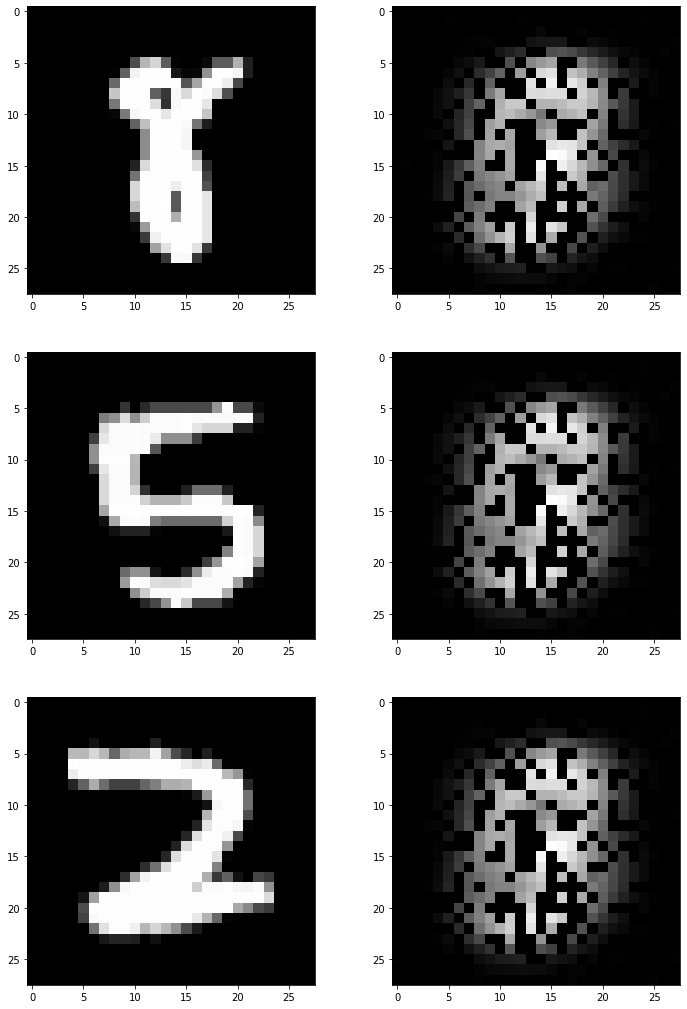

In [20]:
# Autoencoder outputs (Train Set)

model.eval()
with torch.no_grad():

    data = next(iter(train_))
    sample = model(data.to(device))
    _, axs = plt.subplots(3, 2, figsize=(12, 18))
    axs[0, 0].imshow(np.array(data[0]).reshape(28, 28), cmap='gray')
    axs[0, 1].imshow(np.array(sample[0]).reshape(28, 28), cmap='gray')
    axs[1, 0].imshow(np.array(data[1]).reshape(28, 28), cmap='gray')
    axs[1, 1].imshow(np.array(sample[1]).reshape(28, 28), cmap='gray')
    axs[2, 0].imshow(np.array(data[2]).reshape(28, 28), cmap='gray')
    axs[2, 1].imshow(np.array(sample[2]).reshape(28, 28), cmap='gray')

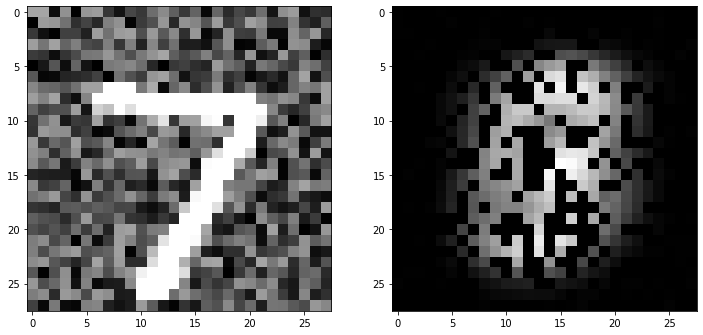

In [21]:
# Autoencoder outputs (Test Set)

model.eval()

data = torch.from_numpy(np.array(anom.iloc[0][1:])/255).float()
sample = model(data.to(device)).detach().numpy()
_, axs = plt.subplots(1, 2, figsize=(12, 18))
axs[0].imshow(np.array(data).reshape(28, 28), cmap='gray')
axs[1].imshow(np.array(sample).reshape(28, 28), cmap='gray')
plt.show();

# Result Analysis

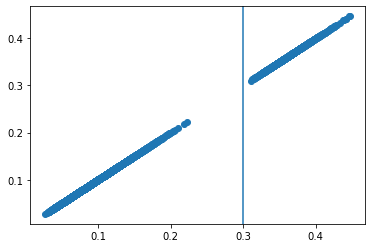

In [22]:
# Loss Comparison

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


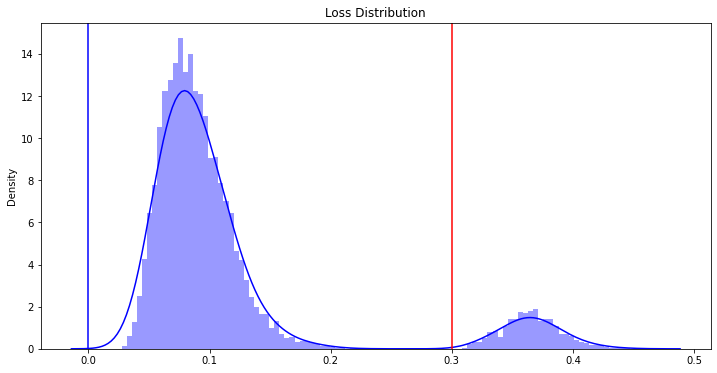

In [23]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

# Matching anomalies and loss values

In [24]:
df = pd.read_csv('data/mnist_test_anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


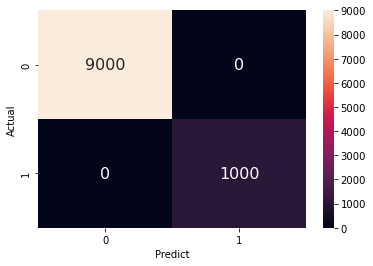

In [25]:
# Confusion Matrix

conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()